# 第1章 基礎

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 4)
from IPython.display import display, Audio
import soundfile as sf
import scipy.signal
import munotes as mn
import requests
import io


---

## 1. 音とは

<u>**A. 波**</u>

<br>

例えば

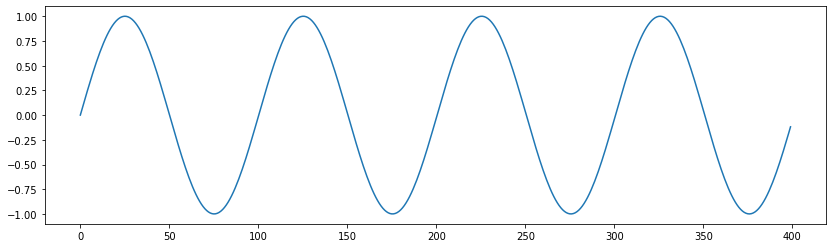

In [2]:
freq = 440
sr = 44100
sec = 1
amp = 1
y = amp * np.sin(np.linspace(0, 2*np.pi * freq * sec, sr*sec))
plt.plot(y[:400])
Audio(y, rate=sr)

こんな波だとこんな音になる



もう少し一般的な音声を聴いてみる
- [CS 101- Sample Sound Files](https://www2.cs.uic.edu/~i101/SoundFiles/)

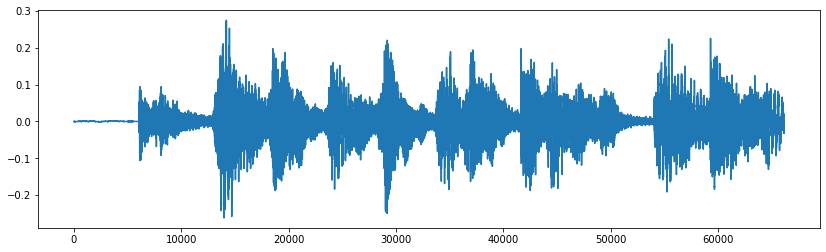

In [3]:
path = 'https://www2.cs.uic.edu/~i101/SoundFiles/CantinaBand3.wav'
res = requests.get(path)
br = io.BufferedReader(io.BytesIO(res.content))
y, sr = sf.read(br)
plt.plot(y)
Audio(y, rate=sr)

適当に拡大してみるとこんな感じ

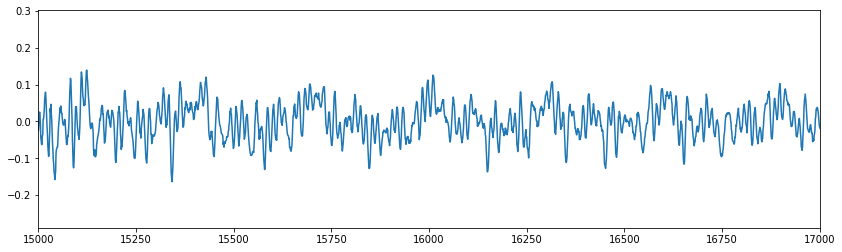

In [4]:
plt.plot(y)
plt.xlim(15000, 17000);

複雑だが波になっているのが分かる

**こんな風に、この世のありとあらゆる音は波で表現することが出来る**


---

## 2. 音と波の関係

音を波で表せることが分かった。では波と音にはどの様な関係があるのだろうか。

In [4]:
def flow(freq=440, sr=44100, sec=1, amp=1):
    y = amp * np.sin(np.linspace(0, 2*np.pi * freq * sec, sr*sec))
    plt.plot(y[:400])
    plt.ylim(-1.1, 1.1)
    plt.show()
    display(Audio(y, rate=sr, normalize=False))

### 1. 周波数

波が細かいと音が高くなる

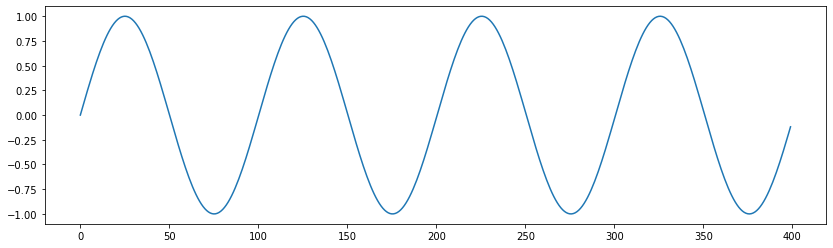

--------------------------------------------------------------------------------


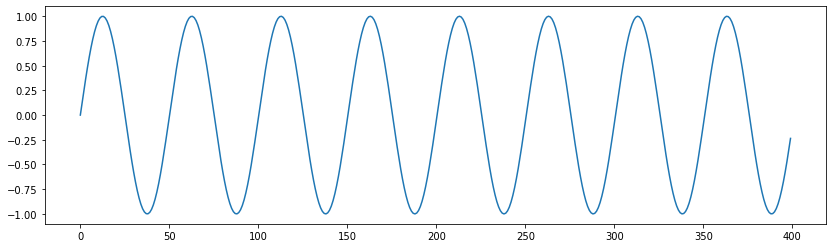

In [5]:
flow(440)
print('-'*80)
flow(880)

波の細かさを**周波数（frequency）** と呼ぶ。これは1秒間に振動した回数を表す。

また、周波数880Hzの音（下）は、440Hzの音（上）の1オクターブ上の音となる。「オクターブ」というのは「周波数の比率が1:2の関係」と定義される。

### 2. 音圧

波が大きいと音が大きくなる。

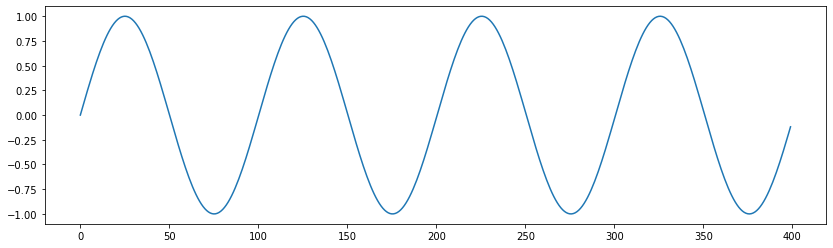

--------------------------------------------------------------------------------


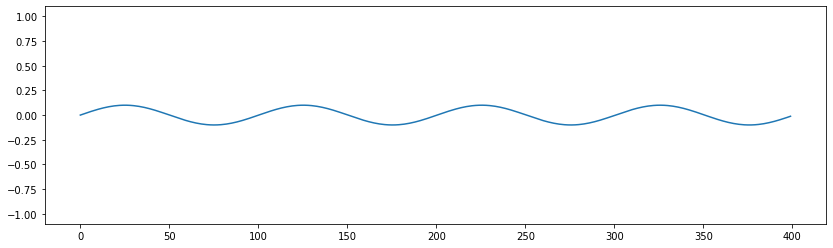

In [7]:
flow(amp=1)
print('-'*80)
flow(amp=0.1)

音の大きさは**音圧**と呼ぶ。圧力の単位はパスカル（Pa）で、音も同じ。ただ音の大きさは人間の聴覚に対して指数的なので、何らかの基準を元に対数をとったdB（デシベル）という単位で扱う。  
また音圧の最大値を**振幅**と呼ぶ。音声波形の縦軸を振幅と表すこともあるが、厳密には違うのかもしれない。

### 3. 音の合成

複数の音を表した波を足し合わせると、それらが混ざった音ができる。

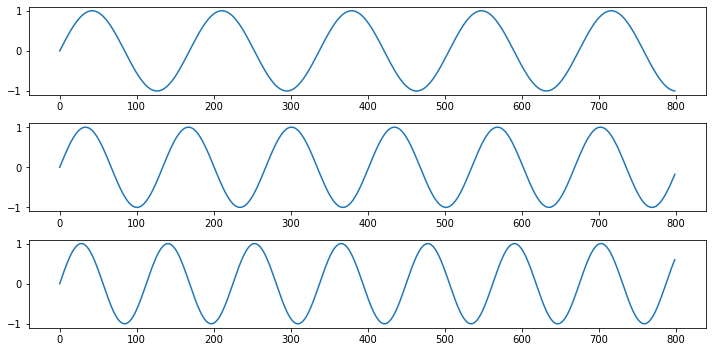

In [6]:
sr = 44100
n1 = mn.Note(60)
n2 = mn.Note(64)
n3 = mn.Note(67)

y1 = n1.sin(sr=sr)
y2 = n2.sin(sr=sr)
y3 = n3.sin(sr=sr)

plt.figure(figsize=(10, 5))
for i in range(1, 4):
    plt.subplot(3, 1, i)
    exec(f'plt.plot(y{i}[:800])')
plt.tight_layout()

display(Audio(y1, rate=sr))
display(Audio(y2, rate=sr))
display(Audio(y3, rate=sr))

これらを足す

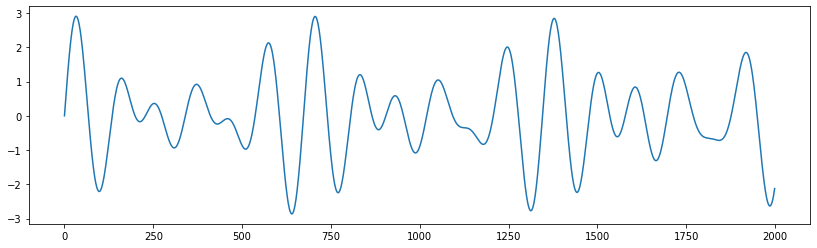

In [7]:
y = y1 + y2 + y3
plt.plot(y[:2000])
Audio(y, rate=sr)

3つの音が混ざった音が出来た

<br>

ここでちょっとした雑学。ノイズキャンセリングのお話。

まず2つの音を用意する。

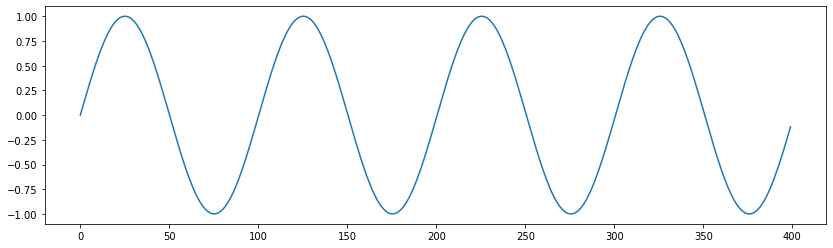

--------------------------------------------------------------------------------


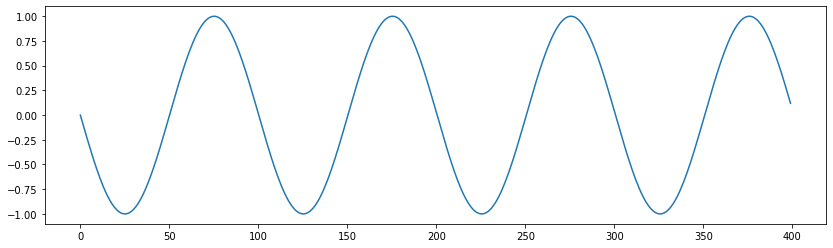

In [8]:
freq, sr, sec, amp = 440, 44100, 1, 1
t = np.arange(0, 1, 1/sr)
y1 = amp * np.sin(2*np.pi*freq*t)
plt.plot(y1[:400])
plt.show()
display(Audio(y1, rate=sr))

print('-'*80)

y2 = amp * np.sin(2*np.pi*freq*t + np.pi)
plt.plot(y2[:400])
plt.show()
display(Audio(y2, rate=sr))

2つの音を用意した。周波数は同じ。ではこの2つを足すとどうなるか。

In [9]:
y = y1 + y2
Audio(y, rate=sr, normalize=False)

何も聞こえない。波形を見てみよう。

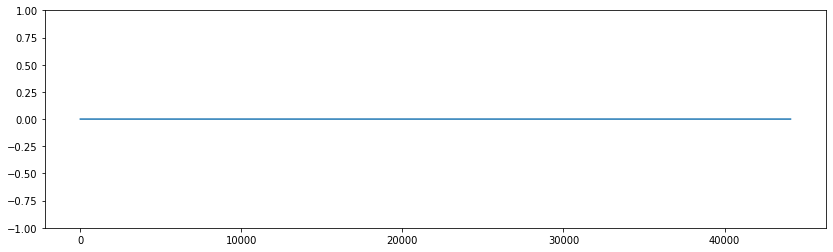

In [12]:
plt.plot(y)
plt.ylim(-1, 1);

実は先程の2つの波形は位相が半分($\pi$)だけずれている。これは**逆位相**といい、2つを足すとちょうど0になる。  
これを活用したのがノイズキャンセリング。入ってきた高周波数の音（ノイズ）の逆位相の音をぶつけることで、ノイズを打ち消している。

実際にやってみる

In [10]:
sr = 44100
y1 = n1.sin(sr=sr)
y2 = n2.sin(sr=sr)
y3 = n3.sin(sr=sr)

y = y1 + y2 + y3
Audio(y, rate=sr)

周波数の異なる3つの音を足した。

で、次に1番高い音の逆位相の音を作る。

In [11]:
freq = n3.freq
y3_ = np.sin(2*np.pi*freq*t + np.pi)
Audio(y3_, rate=sr)

足してみると

In [12]:
y = y + y3_
Audio(y, rate=sr)

1番上の音を消すことが出来た


---

## 3. コンピュータで音を扱う

音をコンピュータで扱うには、音を数値化（デジタル化）する必要がある。  
音は波で表せるので、波を数値化すれば良さそう。  
→ 波を離散化して、一次元の配列として表す

### 音を作る

実際に音を作ってみる。グラフで表したときに波になるような配列を作ればいい。

<br>

先程のsin波の生成を関数化

In [14]:
def sin_wave(freq, sr=44100, amp=1, sec=1):
    t = np.arange(0, sec, 1/sr) # 時間軸の生成
    return amp * np.sin(2 * np.pi * freq * t) # sin波を生成

離散化の細かさをサンプリングレートと呼ぶ。44100を使うことが多い。

- freq: 周波数
- sr: サンプリングレート
- amp: 振幅
- sec: 音の長さ(秒)

適当な周波数を入れてsin波を作ってみる

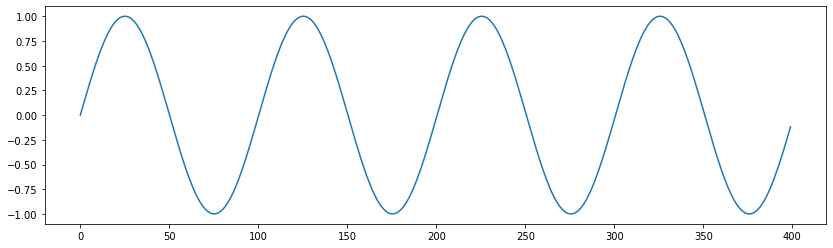

In [15]:
freq = 440 # 周波数
sr = 44100 # サンプリングレート
y = sin_wave(freq=freq, sr=sr)
plt.plot(y[:400])
Audio(y, rate=sr)

### モノラルとステレオ

2つのスピーカーで**同じ音**を鳴らす：**モノラル**  
2つのスピーカーで**違う音**を鳴らす：**ステレオ**

ステレオの場合、2次元の配列で表す必要がある。

<br>

2つの音を作った

In [16]:
sec = 2
t = np.linspace(0, sec, sr*sec)
L = scipy.signal.chirp(t, 0, sec, 880)
R = np.flip(L)
display(Audio(L, rate=sr))
display(Audio(R, rate=sr))

これを合成して一つの音源にするのがモノラル  
モノラルでは左右のスピーカーで同じ音を鳴らしている

In [17]:
y = L + R
Audio(y, rate=sr)

左右に分けて再生するのがステレオ

In [18]:
Audio((L, R), rate=sr)

### チップチューン (おまけ)

ファミコン音楽を作ってみよう

<br>

ファミコンでは3種類の音源チップから音を鳴らしていた (3種類の音しか鳴らせなかった)  
この3種類という制限で作られた音楽をチップチューンというらしい

**参考**  
[Pythonでゲーム音楽（チップチューン）の基本波形を生成（サイン波，矩形波，のこぎり波，三角波，白色雑音） - Wizard Notes](https://www.wizard-notes.com/entry/python/basic-waveforms)

<br>

チップチューンで使われる3種類の音は以下の3つ

#### 矩形波

矩形波 (くけいは)  
方形波ともいうらしい

[scipy.signal.square — SciPy v1.8.0 Manual](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.square.html)

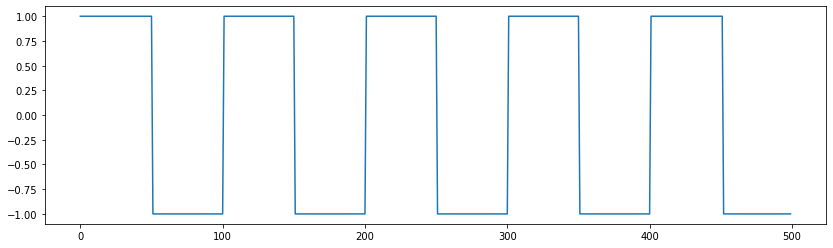

In [19]:
freq, sr, sec = 440, 44100, 1
t = np.arange(0, sec, 1/sr)
y = scipy.signal.square(2*np.pi*freq*t)
plt.plot(y[:500])
Audio(y, rate=sr)

#### 三角波

[scipy.signal.sawtooth — SciPy v1.8.0 Manual](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.sawtooth.html)

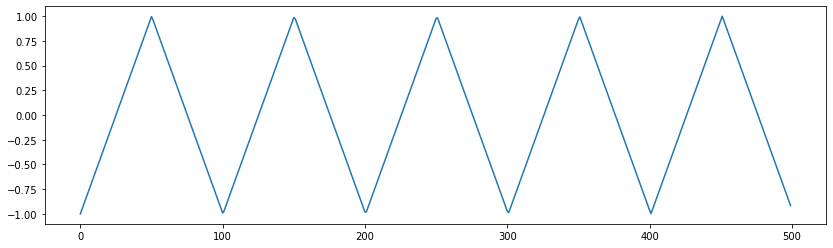

In [20]:
freq, sr, sec = 440, 44100, 1
t = np.arange(0, sec, 1/sr)
y = scipy.signal.sawtooth(2*np.pi*freq*t, 0.5)
plt.plot(y[:500])
Audio(y, rate=sr)

#### ホワイトノイズ

最近ハマっている曲: [Official髭男dism - ホワイトノイズ [Official Video] - YouTube](https://www.youtube.com/watch?v=_ciQX22n9NE)

というのは冗談で、波形の一種。  
正規分布に従って配列を作るとこの音が出来るらしい

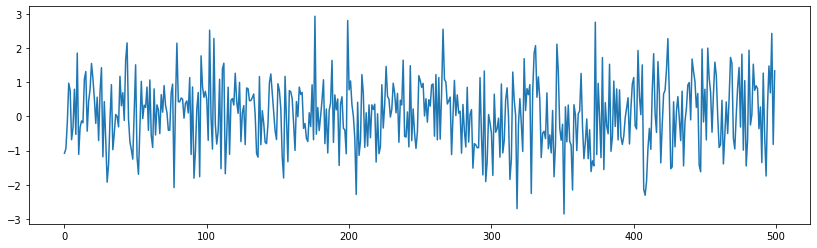

In [21]:
sr, sec = 44100, 1
y = np.random.randn(sr*sec)
plt.plot(y[:500])
Audio(y, rate=sr)

#### 音楽を作ろう

これらの波形を組み合わせて音楽を作ろう。

midiファイルから音符の情報を読み取って波形を生成する。

In [22]:
import music21 as m21

In [23]:
song = m21.converter.parse('midi/jokyoku.mid')
bpm = 120

stream = mn.Stream([])
for part in song:
    if isinstance(part, m21.metadata.Metadata):
        continue
    track = mn.Track([], unit='ql', bpm=bpm)
    for event in part.flat.notesAndRests:
        ql = event.quarterLength
        if isinstance(event, m21.note.Rest):
            track.append((mn.Rest(), ql))
        else:
            notes = mn.Notes(*[note.midi for note in event.pitches])
            track.append((notes, ql))

    stream.append(track)

In [24]:
stream.play(['square', 'square', 'sawtooth'], width=0.5)


---

## 4. Pythonで音を扱う

Pythonで音を扱う際に必要な知識をざっくりと

### NumPy

[NumPy](https://numpy.org/)

行列計算を高速で行うPythonライブラリ。  
音声波形を`ndarray`という形式で読み込むことで、波形に対する高速な演算が可能になる

In [25]:
import numpy as np # numpyの読み込み
array = np.array([1, 2, 3, 4, 5]) # 適当な配列
print(type(array)) # nuympy.ndarrayという型で扱われている

<class 'numpy.ndarray'>


### 音声読み込み

音声ファイルを配列（`np.ndarray`）として読み込む。  
これをしないと分析ができない

#### soundfile

音声ファイルの読み書きができる。  
[SoundFile — PySoundFile 0.10.3post1-1-g0394588 documentation](https://pysoundfile.readthedocs.io/en/latest/)

In [26]:
import soundfile as sf

対応しているフォーマットは以下

In [27]:
sf.available_formats()

{'AIFF': 'AIFF (Apple/SGI)',
 'AU': 'AU (Sun/NeXT)',
 'AVR': 'AVR (Audio Visual Research)',
 'CAF': 'CAF (Apple Core Audio File)',
 'FLAC': 'FLAC (Free Lossless Audio Codec)',
 'HTK': 'HTK (HMM Tool Kit)',
 'SVX': 'IFF (Amiga IFF/SVX8/SV16)',
 'MAT4': 'MAT4 (GNU Octave 2.0 / Matlab 4.2)',
 'MAT5': 'MAT5 (GNU Octave 2.1 / Matlab 5.0)',
 'MPC2K': 'MPC (Akai MPC 2k)',
 'OGG': 'OGG (OGG Container format)',
 'PAF': 'PAF (Ensoniq PARIS)',
 'PVF': 'PVF (Portable Voice Format)',
 'RAW': 'RAW (header-less)',
 'RF64': 'RF64 (RIFF 64)',
 'SD2': 'SD2 (Sound Designer II)',
 'SDS': 'SDS (Midi Sample Dump Standard)',
 'IRCAM': 'SF (Berkeley/IRCAM/CARL)',
 'VOC': 'VOC (Creative Labs)',
 'W64': 'W64 (SoundFoundry WAVE 64)',
 'WAV': 'WAV (Microsoft)',
 'NIST': 'WAV (NIST Sphere)',
 'WAVEX': 'WAVEX (Microsoft)',
 'WVE': 'WVE (Psion Series 3)',
 'XI': 'XI (FastTracker 2)'}

mp3には対応していないので注意。

`sf.read()`で読み込みが可能。配列とサンプリングレートが返される。

In [28]:
path = '../sample-sounds/ohayo.wav'
y, sr = sf.read(path)
print(sr)
print(y.shape)
y

44100
(49536, 2)


array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

（信号長 x チャンネル数）の配列が返される。

一次元にしたい場合は`np.mean()`で平均を取ったり`np.sum()`で和を取ったりすれば良い。

In [31]:
display(np.mean(y, axis=1))
display(np.sum(y, axis=1))

array([0., 0., 0., ..., 0., 0., 0.])

array([0., 0., 0., ..., 0., 0., 0.])

#### audiofile

様々なフォーマットに対応したライブラリ。内部で使っているのはsoundfileなので使い方はあまり変わらない。soundfileで対応していないフォーマットを内部でwavに変換してくれるだけ。  
[audiofile — Documentation](https://audeering.github.io/audiofile/)

In [29]:
import audiofile

In [30]:
y, sr = audiofile.read(path)
print(sr)
print(y.shape)
y

44100
(2, 49536)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

soundfileと違って（チャンネル数 x 信号長）の配列が返されることに注意。

その他、librosaやtorchaudioなどの音声解析を行うライブラリには音声ファイルの読み込み機能が大体ついているので、それらを使う場合はそこから読み込むと良い。

### 音声埋め込み

ipython notebook形式(.ipynb)での音声埋め込み  
→ `IPython.display.Audio()`を使用

[Module: display — IPython 8.1.0 documentation](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html)

In [31]:
from IPython.display import display
from IPython.display import Audio

`display()`に引数としてAudioオブジェクトを与えることで埋め込みができる  

音声ファイルの場合 : pathを入力

In [32]:
path = '../sample-sounds/ohayo.wav'
display(Audio(path))

最後に置かれたオブジェクトは勝手に表示されるのでAudioだけでもいい

In [36]:
Audio(path)

web上のファイルも可

In [40]:
Audio('http://pro-video.jp/voice/announce/mp3/ohayo01mayu.mp3')

配列の場合 : 配列とサンプリングレートを入力  
ステレオ音源の場合は（チャンネル数 x 信号長）の配列を与える

In [43]:
sr = 44100
y = sin_wave(freq=440, sr=sr)
Audio(y, rate=sr)

`normalize=True`とすると正規化された状態で埋め込まれる。  
デフォルトでTrueになっているため、音量を変更したい場合はFalseと示す必要がある  
(`normalize=False`とする場合、配列の値は-1 ~ 1に収まっている必要がある)

In [45]:
# 音量を 1/10 にする
y *= 0.1
Audio(y, rate=sr, normalize=False)